In [ ]:
import os
import pandas as pd
import numpy as np
import ast
import json
import re
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax

import tempfile

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as score

from  matplotlib import ticker
from  matplotlib.ticker import FuncFormatter
from tqdm import tqdm

In [ ]:
import jieba
from jieba import analyse
jieba.enable_paddle()

Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
s2vmodel = SentenceTransformer("uer/sbert-base-chinese-nli")

In [ ]:
measures = ['ClicksRel','ClicksKeyrel','ClicksUse','ClicksIrrel','ClicksNonuse',
            'DwellIrrel','DwellNonuse','MissRel']

behaviors = ['QueryLength','UniqueTerm','NewTerm','QuerySim',
             'ActionCount','ScrollDist','HoverCount','PageVisit','ClickCount',
             'AvgClickRank','Clicks@3','Clicks@5','Clicks@5+','ClickDepth',
             'TimeFirstClick','TimeLastClick','ContentDwellTime','QueryDwellTime']

def queryTermsCompare(query, last_query):
    query = splitKeyWord(query)
    last_query = splitKeyWord(last_query)
    new_unique_term = [word for word in query if (word not in last_query)]
    shared_unique_term = [word for word in query if (word in last_query)]
    total_unique_term = [word for word in query] + [word for word in last_query]
    unique_term = len(set(total_unique_term))
    new_term = len(set(new_unique_term))/len(set(total_unique_term))
    shared_term = len(set(shared_unique_term))/len(set(total_unique_term))
    return unique_term, new_term, shared_term


def splitKeyWord(query):
    regex = r"[\u4e00-\ufaff]|[0-9]+|[a-zA-Z]+\'*[a-z]*"
    matches = re.findall(regex, query, re.UNICODE)
    return matches

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/kdd_rawfeatures.csv', encoding='UTF-8')

data[measures] = 0
data[behaviors] = 0

# data['ClicksRel'] = 0
# data['ClicksKeyrel'] = 0
# data['ClicksUse'] = 0

# data['ClicksIrrel'] = 0
# data['ClicksNonuse'] = 0
# data['DwellIrrel'] = 0
# data['DwellNonuse'] = 0
# data['MissRel'] = 0

data_eval = pd.DataFrame(columns=data.columns)

sessions_list = list(data['session'].drop_duplicates().values)
for session in sessions_list:
    data_s = data.loc[data['session']==session]
    query_unique = {}
    query_all = []
    last_query = ''
    query_order = 1
    for index, row in data_s.iterrows():
        row['query_order'] = query_order
        query_order += 1
        row['QueryToken'] = analyse.extract_tags(row['query'])
        row['TokenLength'] = len(row['QueryToken'])
        row['QueryLength'] = len(splitKeyWord(row['query']))
        row['UniqueTerm'] = queryTermsCompare(row['query'],last_query)[0]
        if row['query'] in query_all:
            row['NewTerm'] = 0
            row['QuerySim'] = 0
        else:
            row['NewTerm'] = queryTermsCompare(row['query'],last_query)[1]
            row['QuerySim'] = queryTermsCompare(row['query'],last_query)[2]
        query_all.append(row['query'])
        last_query = row['query']

        actions = ast.literal_eval(row['action'])
        row['ActionCount'] = len(actions)
        row['ScrollDist'] = row['distance']
        row['HoverCount'] = actions.count('HOVER')
        row['PageVisit'] = actions.count('GOTO_PAGE')

        clicks = ast.literal_eval(row['click'].replace('rb_',''))
        clicks = list(map(int, clicks))
        click_time = ast.literal_eval(row['click_time'])

        row['ClickPage'] = len(set(clicks))
        row['ClickCount'] = len(clicks)
        row['AvgClickRank'] = sum(clicks)/len(clicks) + 1 if clicks else 0
        row['Clicks@3'] = len([item for item in clicks if item < 3])
        row['Clicks@5'] = len([item for item in clicks if item < 5])
        row['Clicks@5+'] = len([item for item in clicks if item >= 5])
        row['ClickDepth'] = max(clicks)+1 if clicks else 0
        row['TimeFirstClick'] = click_time[0]/1000 if clicks else 0
        row['TimeLastClick'] = click_time[-1]/1000 if clicks else 0

        row['click'] = ast.literal_eval(row['click'])
        row['dwelltime_doc'] = ast.literal_eval(row['dwelltime_doc'])

        row['ContentDwellTime'] = sum(row['dwelltime_doc'])/1000
        row['QueryDwellTime'] = row['dwelltime_query']/1000

        relevance_t = dict(ast.literal_eval(row['relevance_t']))
        usefulness = dict(ast.literal_eval(row['usefulness']))

        relevance_list = [relevance_t[i] if i in relevance_t else 0
                          for i in range(int(max(relevance_t))+1)] if relevance_t else [0]
        usefulness_list = [usefulness['rb_'+str(i)] if 'rb_'+str(i) in usefulness else 0
                           for i in range(int(max(usefulness).replace('rb_',''))+1)] if usefulness else [0]

        relevance_ideal = relevance_list.copy()
        relevance_ideal.sort(reverse=True)
        usefulness_ideal = usefulness_list.copy()
        usefulness_ideal.sort(reverse=True)

        if len(relevance_list)>1:
            ndcg_r = ndcg_score(np.array([relevance_list]),np.array([relevance_ideal]))
        elif len(relevance_list)==1 and relevance_list != [0]:
            ndcg_r = 1
        else:
            ndcg_r = 0

        if len(usefulness_list)>1:
            ndcg_u = ndcg_score(np.array([usefulness_list]),np.array([usefulness_ideal]))
        elif len(usefulness_list)==1 and usefulness_list != [0]:
            ndcg_u = 1
        else:
            ndcg_u = 0

        rr_r = relevance_list.index(max(relevance_list))+1 if max(relevance_list)!=0 else 11
        rr_u = usefulness_list.index(max(usefulness_list))+1 if max(usefulness_list)!=0 else 11

        dcg_rel = sum([relevance_list[i]/math.log(i+2,2) for i in range(len(relevance_list))])
        dcg_use = sum([usefulness_list[i]/math.log(i+2,2) for i in range(len(usefulness_list))])

        if row['query'] not in query_unique:
            query_unique[row['query']] = row['click']
            unique_query = True
        else:
            unique_query = False
            dcg_rel = 0
            dcg_use = 0

        row['dcg_rel'] = dcg_rel
        row['dcg_use'] = dcg_use

        row['ndcg_r'] = ndcg_r
        row['ndcg_u'] = ndcg_u
        row['rr_r'] = rr_r
        row['rr_u'] = rr_u

        Rel_t = { key: value for key, value in relevance_t.items() if value >= 2}

        for i in range(len(clicks)):
            relevance_i = relevance_t[clicks[i]] if clicks[i] in relevance_t else 0
            usefulness_i = usefulness[row['click'][i]] if row['click'][i] in usefulness else 0
            dwelltime_i = row['dwelltime_doc'][i] if i < len(row['dwelltime_doc']) else 0

            if clicks[i] in Rel_t:
                del Rel_t[clicks[i]]

            if not (not unique_query and row['click'][i] in query_unique[row['query']]):

                row['ClicksRel'] += 1 if relevance_i >= 2 else 0
                row['ClicksKeyrel'] += 1 if relevance_i >= 3 else 0
                row['ClicksUse'] += 1 if usefulness_i > 2 else 0
            elif not unique_query:
                query_unique[row['query']].append(row['click'][i])

            row['ClicksIrrel'] += 1 if relevance_i <= 1 else 0
            row['ClicksNonuse'] += 1 if usefulness_i == 1 else 0
            row['DwellIrrel'] += dwelltime_i/1000 if relevance_i <= 1 else 0
            row['DwellNonuse'] += dwelltime_i/1000 if usefulness_i == 1 else 0

        row['MissRel'] = len(Rel_t)

        data_eval = data_eval.append(row, ignore_index = True)


Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.978 seconds.
Prefix dict has been built successfully.


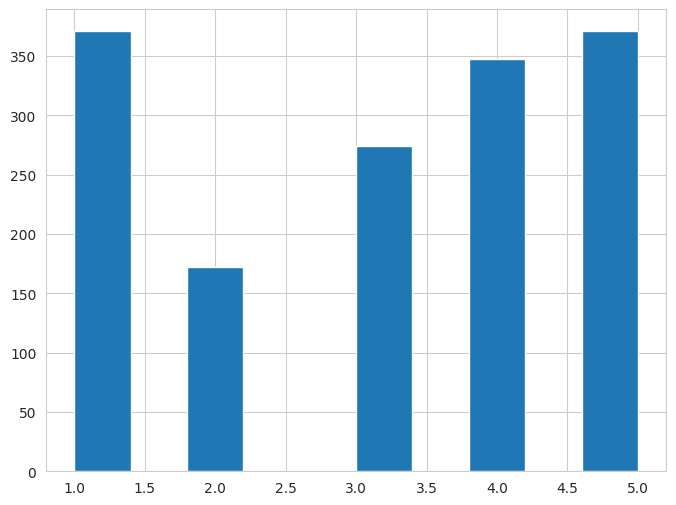

In [ ]:
data_eval['satisfaction'].hist()

In [ ]:
query_vec = s2vmodel.encode(data_eval['query'])
data_eval['vector'] = query_vec.tolist()

In [ ]:
eval_list = ['dcg_rel','dcg_use','ClicksRel','ClicksKeyrel','ClicksUse',
             'ClicksIrrel','ClicksNonuse','DwellIrrel','DwellNonuse','MissRel']
eval_list_ratet = [item+'_ratet' for item in eval_list]
eval_list_ratep = [item+'_ratep' for item in eval_list]

In [ ]:
eval_session = pd.DataFrame()

for session in sessions_list:
    eval_dict = {}
    eval_dict['session'] = session
    eval_dict['user'] = session.split('-')[0]
    eval_dict['task'] = session.split('-')[1]

    data_s = data_eval.loc[data_eval['session']==session]
    eval_dict['satisfaction'] = data_s['satisfaction'].values[0]
    session_dwell = data_s['dwelltime_query'].sum()/1000
    session_clickpage = data_s['ClickPage'].sum()

    for e in eval_list:
        eval_dict[e] = data_s[e].sum()
        eval_dict[e+'_ratet'] = eval_dict[e]/session_dwell
        eval_dict[e+'_ratep'] = eval_dict[e]/session_clickpage

    eval_session = eval_session.append(eval_dict, ignore_index=True)


In [ ]:
for eval in eval_list:
    print(eval,stats.spearmanr(eval_session[eval],eval_session['satisfaction']))

dcg_rel SpearmanrResult(correlation=-0.1261416644781742, pvalue=0.007381249685246074)
dcg_use SpearmanrResult(correlation=-0.018093698878589984, pvalue=0.701876139063142)
ClicksRel SpearmanrResult(correlation=-0.10505062191376455, pvalue=0.025851773760486012)
ClicksKeyrel SpearmanrResult(correlation=0.02143549370523883, pvalue=0.6501866677870047)
ClicksUse SpearmanrResult(correlation=0.07972409780588482, pvalue=0.09118316118287896)
ClicksIrrel SpearmanrResult(correlation=-0.27364644121608783, pvalue=3.5957181175217e-09)
ClicksNonuse SpearmanrResult(correlation=-0.38153599790453824, pvalue=4.837233395230505e-17)
DwellIrrel SpearmanrResult(correlation=-0.21840796508722482, pvalue=2.913481147492277e-06)
DwellNonuse SpearmanrResult(correlation=-0.3403222598758568, pvalue=1.1542126533639008e-13)
MissRel SpearmanrResult(correlation=-0.10076402390202825, pvalue=0.03259602085374654)


In [ ]:
for eval in eval_list:
    print(eval,stats.kendalltau(eval_session[eval],eval_session['satisfaction']))

dcg_rel KendalltauResult(correlation=-0.09347737562886121, pvalue=0.007316253661877201)
dcg_use KendalltauResult(correlation=-0.013823796419359251, pvalue=0.6917247022868589)
ClicksRel KendalltauResult(correlation=-0.0821969120906527, pvalue=0.024225389165501446)
ClicksKeyrel KendalltauResult(correlation=0.017109177937785956, pvalue=0.6464914721439092)
ClicksUse KendalltauResult(correlation=0.06281071698784219, pvalue=0.089942942135302)
ClicksIrrel KendalltauResult(correlation=-0.22171193367390732, pvalue=4.307435796999122e-09)
ClicksNonuse KendalltauResult(correlation=-0.3145651179382915, pvalue=1.3345691565126295e-16)
DwellIrrel KendalltauResult(correlation=-0.1687382989003519, pvalue=2.7425056068653647e-06)
DwellNonuse KendalltauResult(correlation=-0.2618951458110647, pvalue=6.873369270182959e-13)
MissRel KendalltauResult(correlation=-0.0756133746396418, pvalue=0.03303406835460104)


In [ ]:
eval_session['satisfaction']=eval_session[['satisfaction','task']].groupby('task').transform(
    lambda x: (x - x.median())/(x.quantile(0.75)-x.quantile(0.25)))

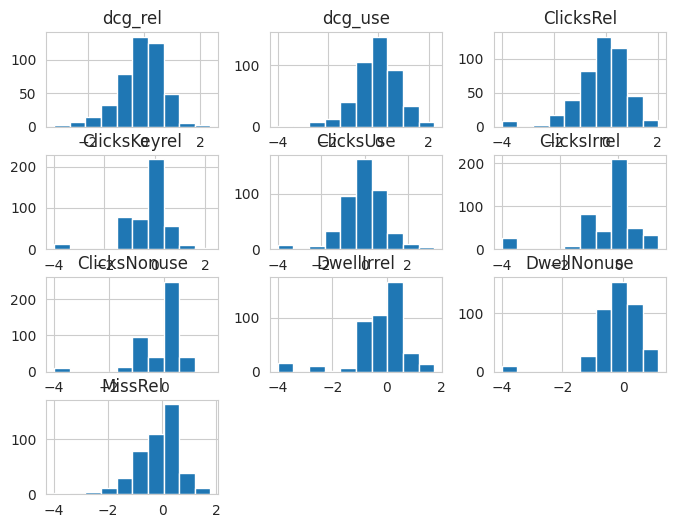

In [ ]:
# eval_session_nor = eval_session[['dcg_rel','ClicksRel','ClicksIrrel','']].copy()
eval_session_nor = eval_session[eval_list].copy()
eval_session_nor = np.log(eval_session_nor+0.001)
eval_session_nor['task']=eval_session['task']
eval_session_nor=eval_session_nor.groupby('task').transform(
    lambda x: (x - x.median())/(x.quantile(0.75)-x.quantile(0.25)))
# eval_session_nor=eval_session_nor.groupby('task').transform(
#     lambda x: (x - x.mean())/x.std())
eval_session_nor = np.clip(eval_session_nor, -4, 4)
mpl.rcParams['figure.figsize'] = (8, 6)
eval_session_nor.hist()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.show()

In [ ]:
eval_session['satisfaction']=eval_session[['satisfaction','task']].groupby('task').transform(
    lambda x: (x - x.median())/(x.quantile(0.75)-x.quantile(0.25)))
for eval in eval_list:
    print(eval,stats.pearsonr(eval_session_nor[eval],eval_session['satisfaction']))

dcg_rel (-0.13212788990802984, 0.004994658816325487)
dcg_use (-0.07004403037716443, 0.13792882580188884)
ClicksRel (-0.13510844676162082, 0.004088033190011643)
ClicksKeyrel (-0.05233942331385745, 0.26787982867425447)
ClicksUse (0.034477946695622264, 0.46565282463519564)
ClicksIrrel (-0.15713698674566523, 0.0008230916940279227)
ClicksNonuse (-0.2354090916934916, 4.393884728247158e-07)
DwellIrrel (-0.14994815412229673, 0.0014222955810380248)
DwellNonuse (-0.25396346388915436, 4.7026363894844635e-08)
MissRel (-0.13360428225453466, 0.004525086791149239)


In [ ]:
gain_cost_pair = [['dcg_rel','ClicksIrrel'],
                  ['dcg_use','ClicksNonuse'],
                  ['ClicksRel','ClicksIrrel'],
                  ['ClicksKeyrel','ClicksIrrel'],
                  ['ClicksUse','ClicksNonuse'],
                  ['ClicksRel','DwellIrrel'],
                  ['ClicksUse','DwellNonuse'],
                  ['ClicksRel','MissRel']]


In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")

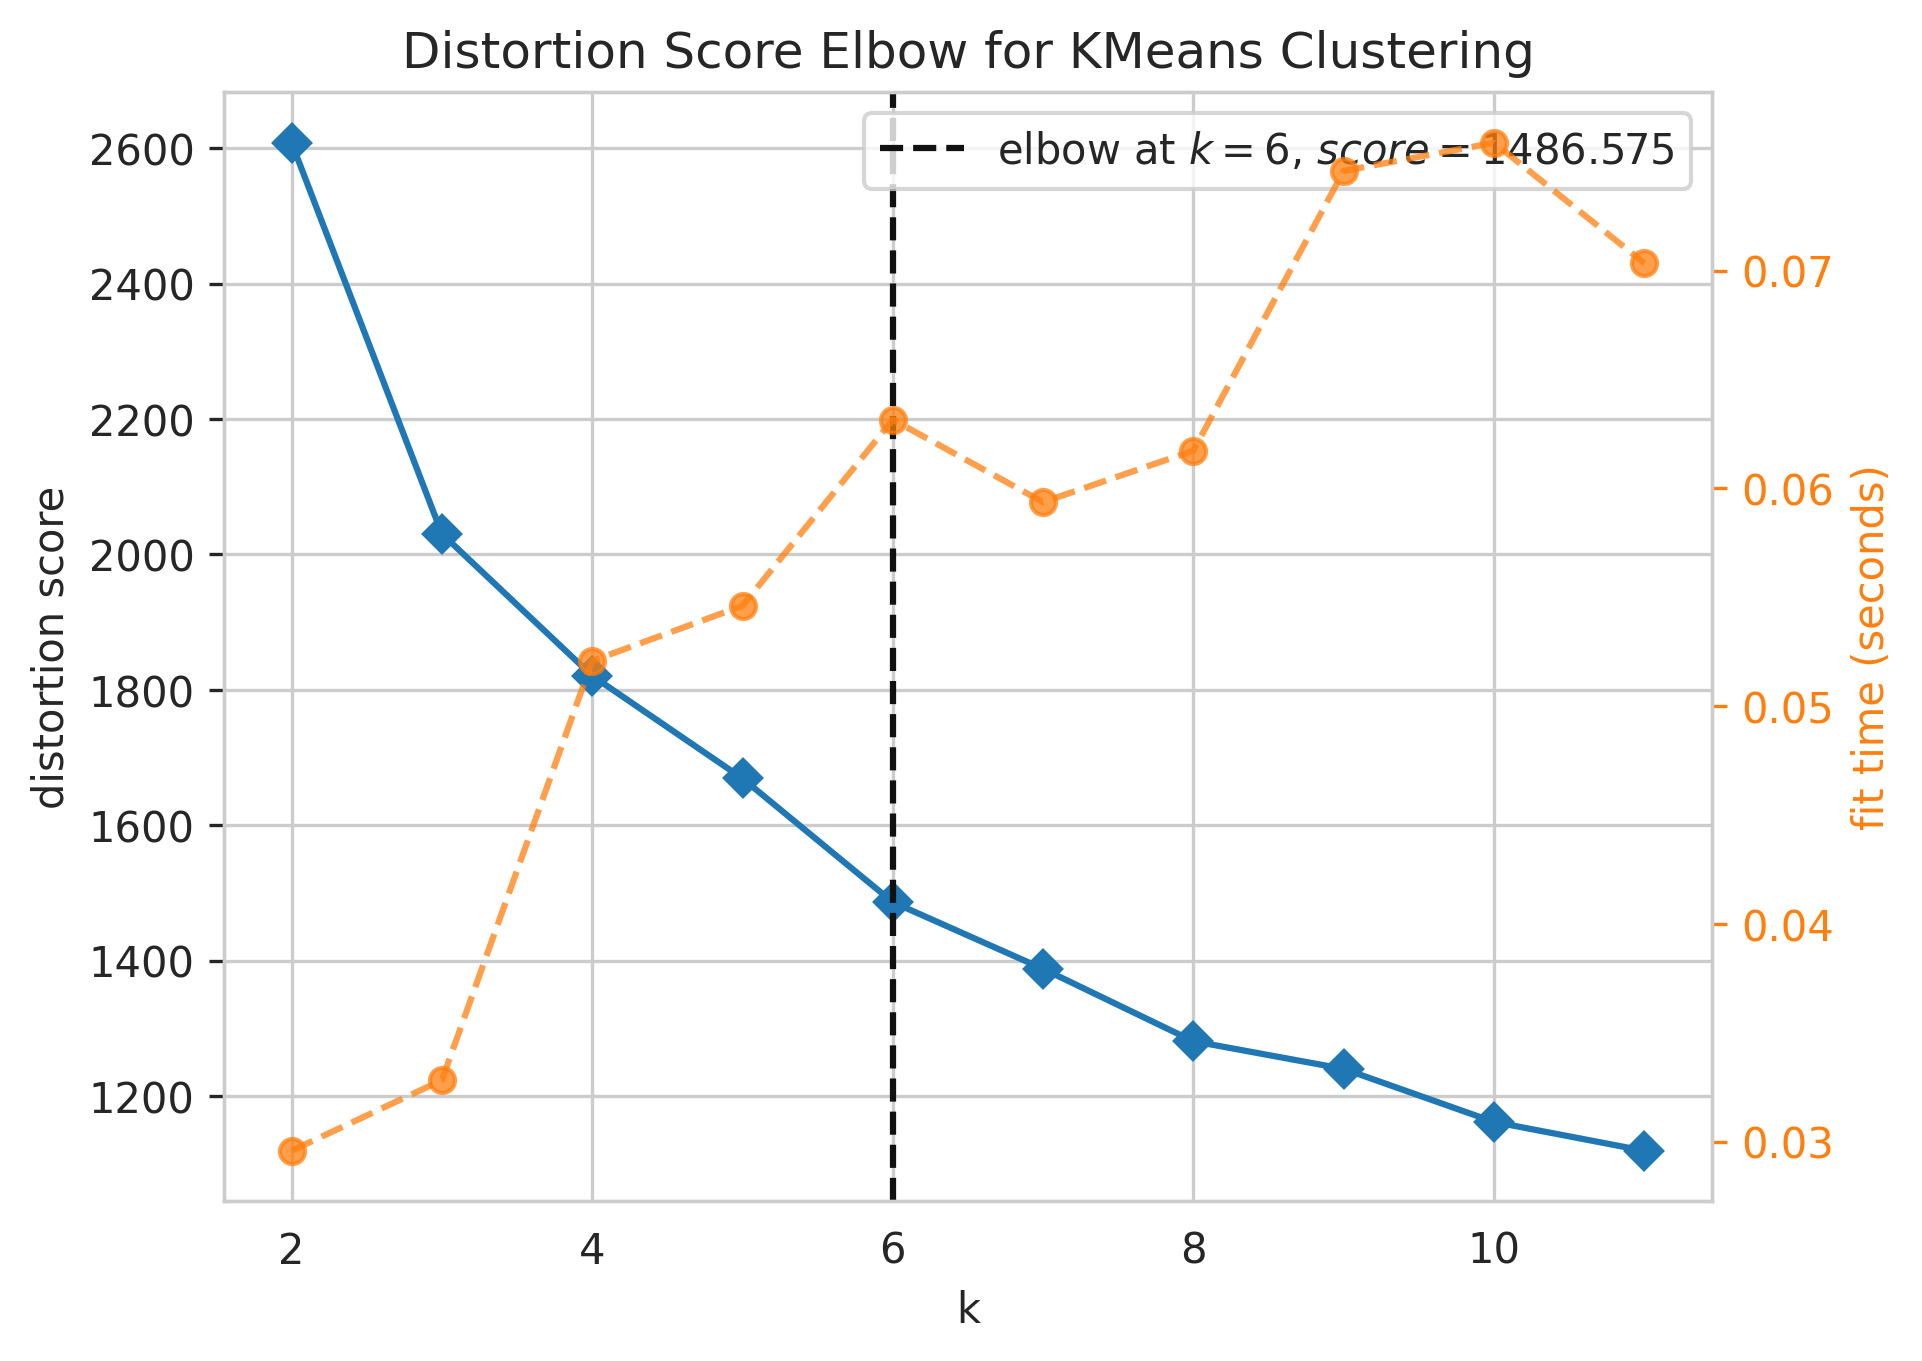

In [ ]:
scaler = MinMaxScaler()
model = KMeans()
fig, ax = plt.subplots(dpi=300)
visualizer = KElbowVisualizer(model, k=(2,12),metric='distortion',ax=ax)

visualizer.fit(eval_session_nor)
cluster_n = visualizer.elbow_value_
visualizer.show()

model = KMeans(cluster_n).fit(eval_session_nor)
clusters = eval_session_nor.copy()
clusters['label'] = model.labels_

In [ ]:
for i in range(0,5):
    print(len(clusters.loc[clusters['label']==i]))

9
166
114
20
25


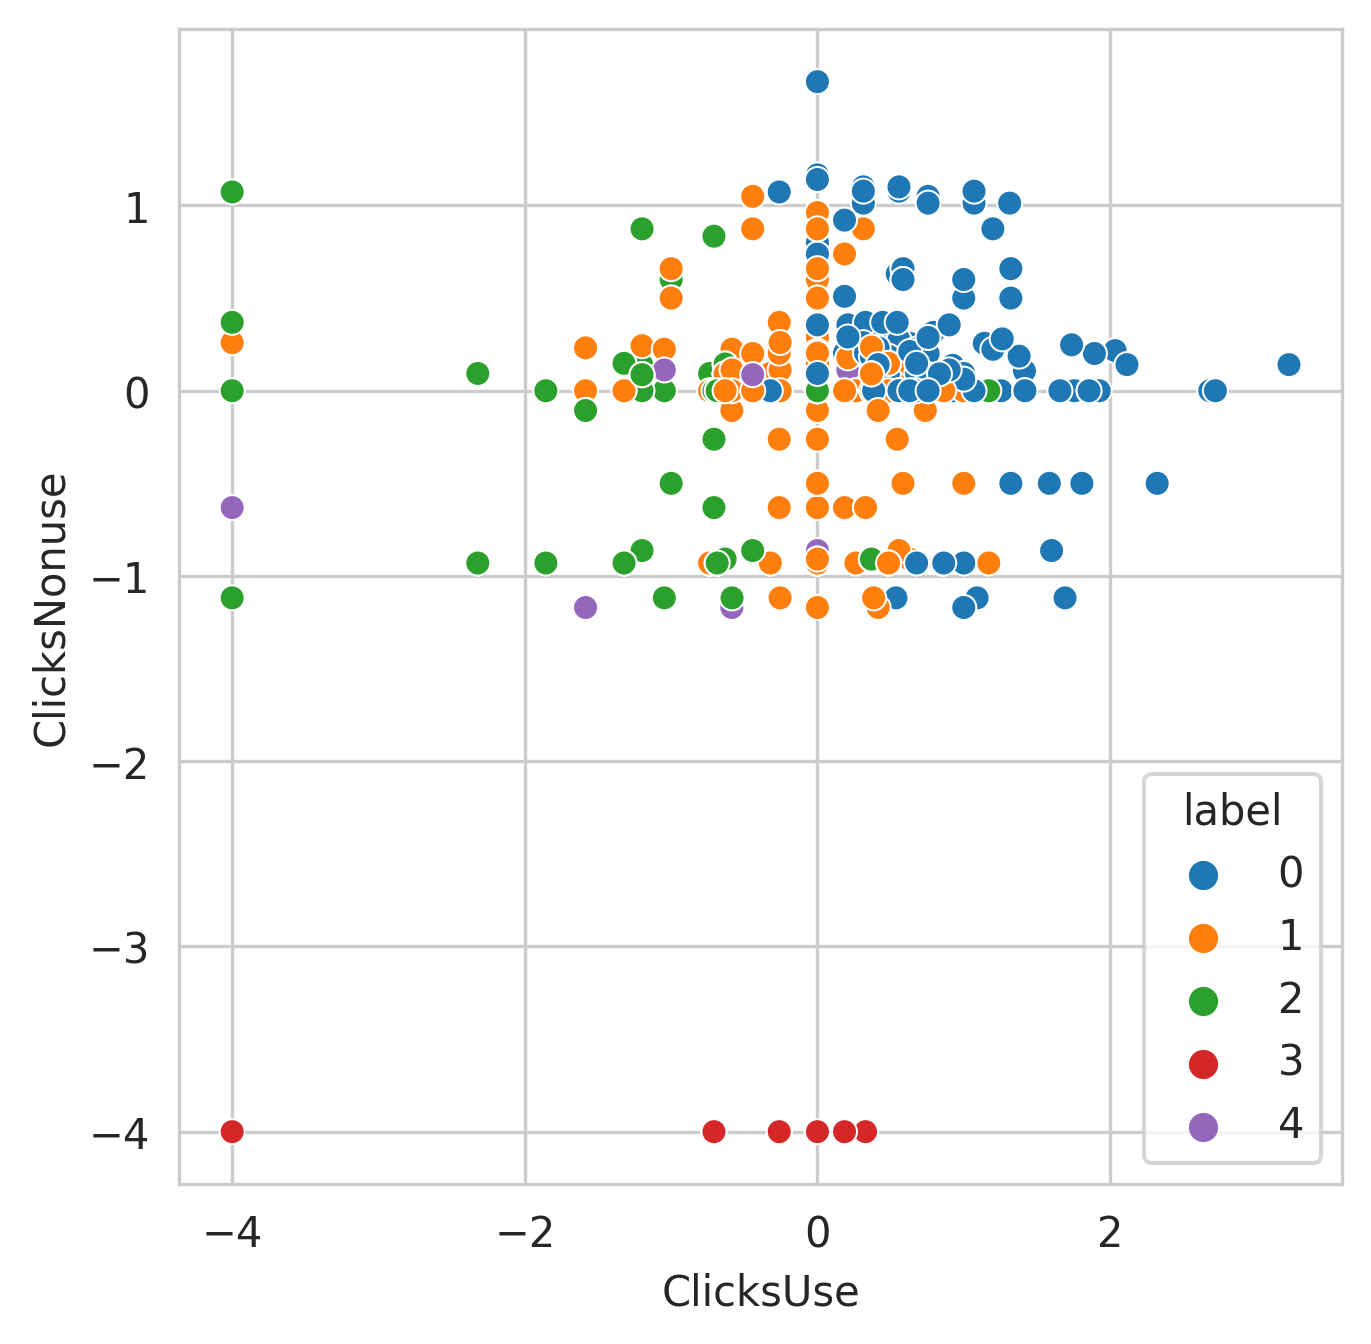

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=300)
sns.scatterplot(x='ClicksUse',y='ClicksNonuse',
                    hue='label',
                    data=clusters,ax=ax,
                    palette="tab10")
sns.set(font_scale = 1.5)
plt.show()

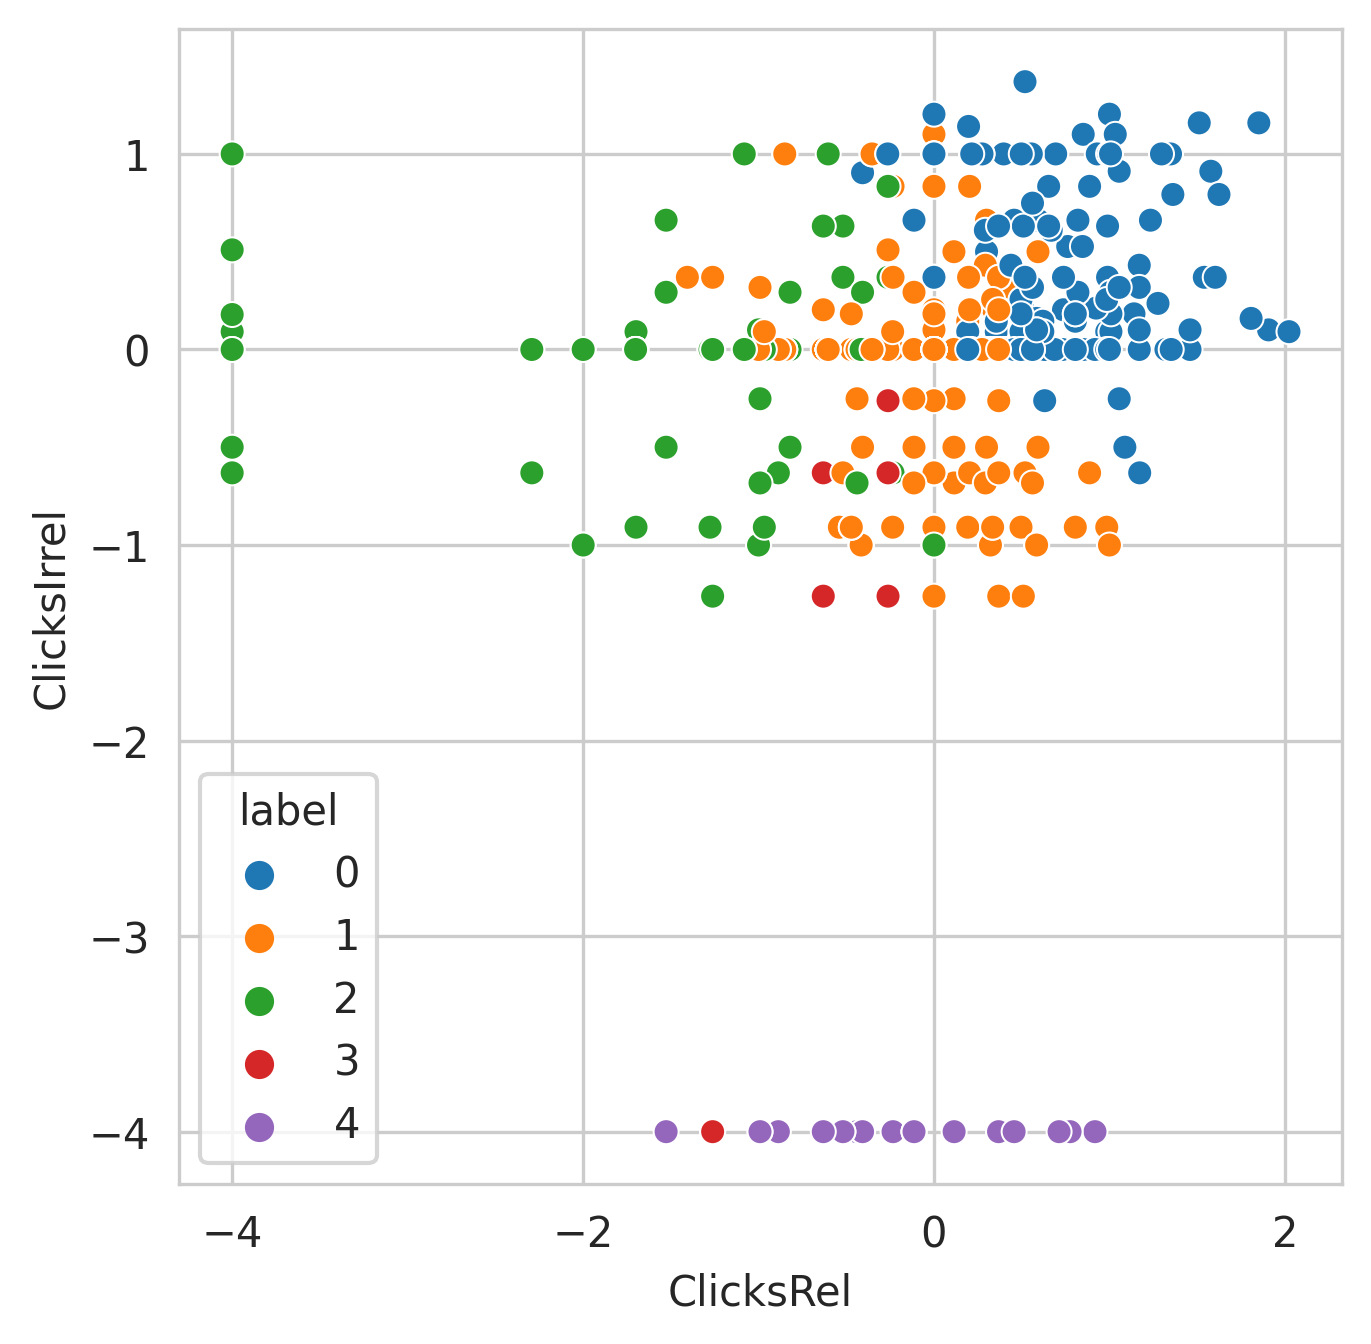

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=300)
sns.scatterplot(x='ClicksRel',y='ClicksIrrel',
                    hue='label',
                    data=clusters,ax=ax,
                    palette="tab10")
sns.set(font_scale = 1.5)
plt.show()

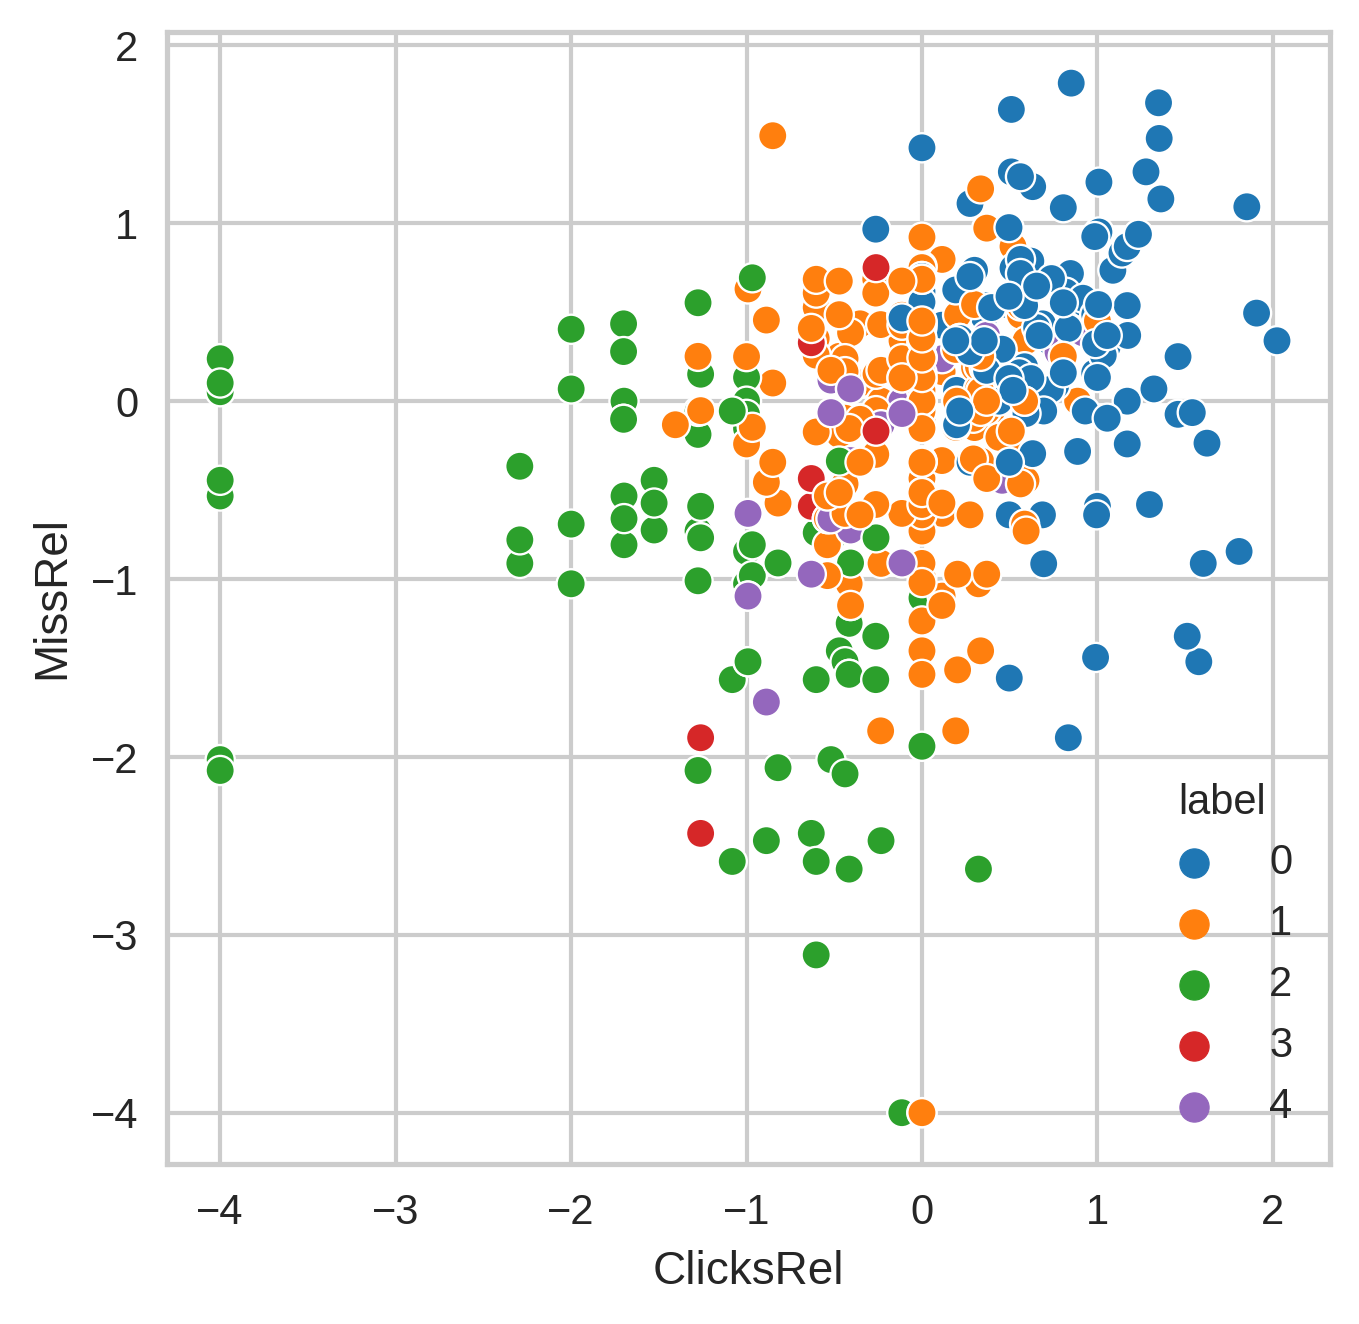

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=300)
sns.scatterplot(x='ClicksRel',y='MissRel',
                    hue='label',
                    data=clusters,ax=ax,
                    palette="tab10")
plt.show()

In [ ]:
clusters.to_csv('/content/drive/MyDrive/Data/kddclusters.csv')

In [ ]:
clusters = pd.read_csv('/content/drive/MyDrive/Data/kddclusters.csv', index_col = [0])

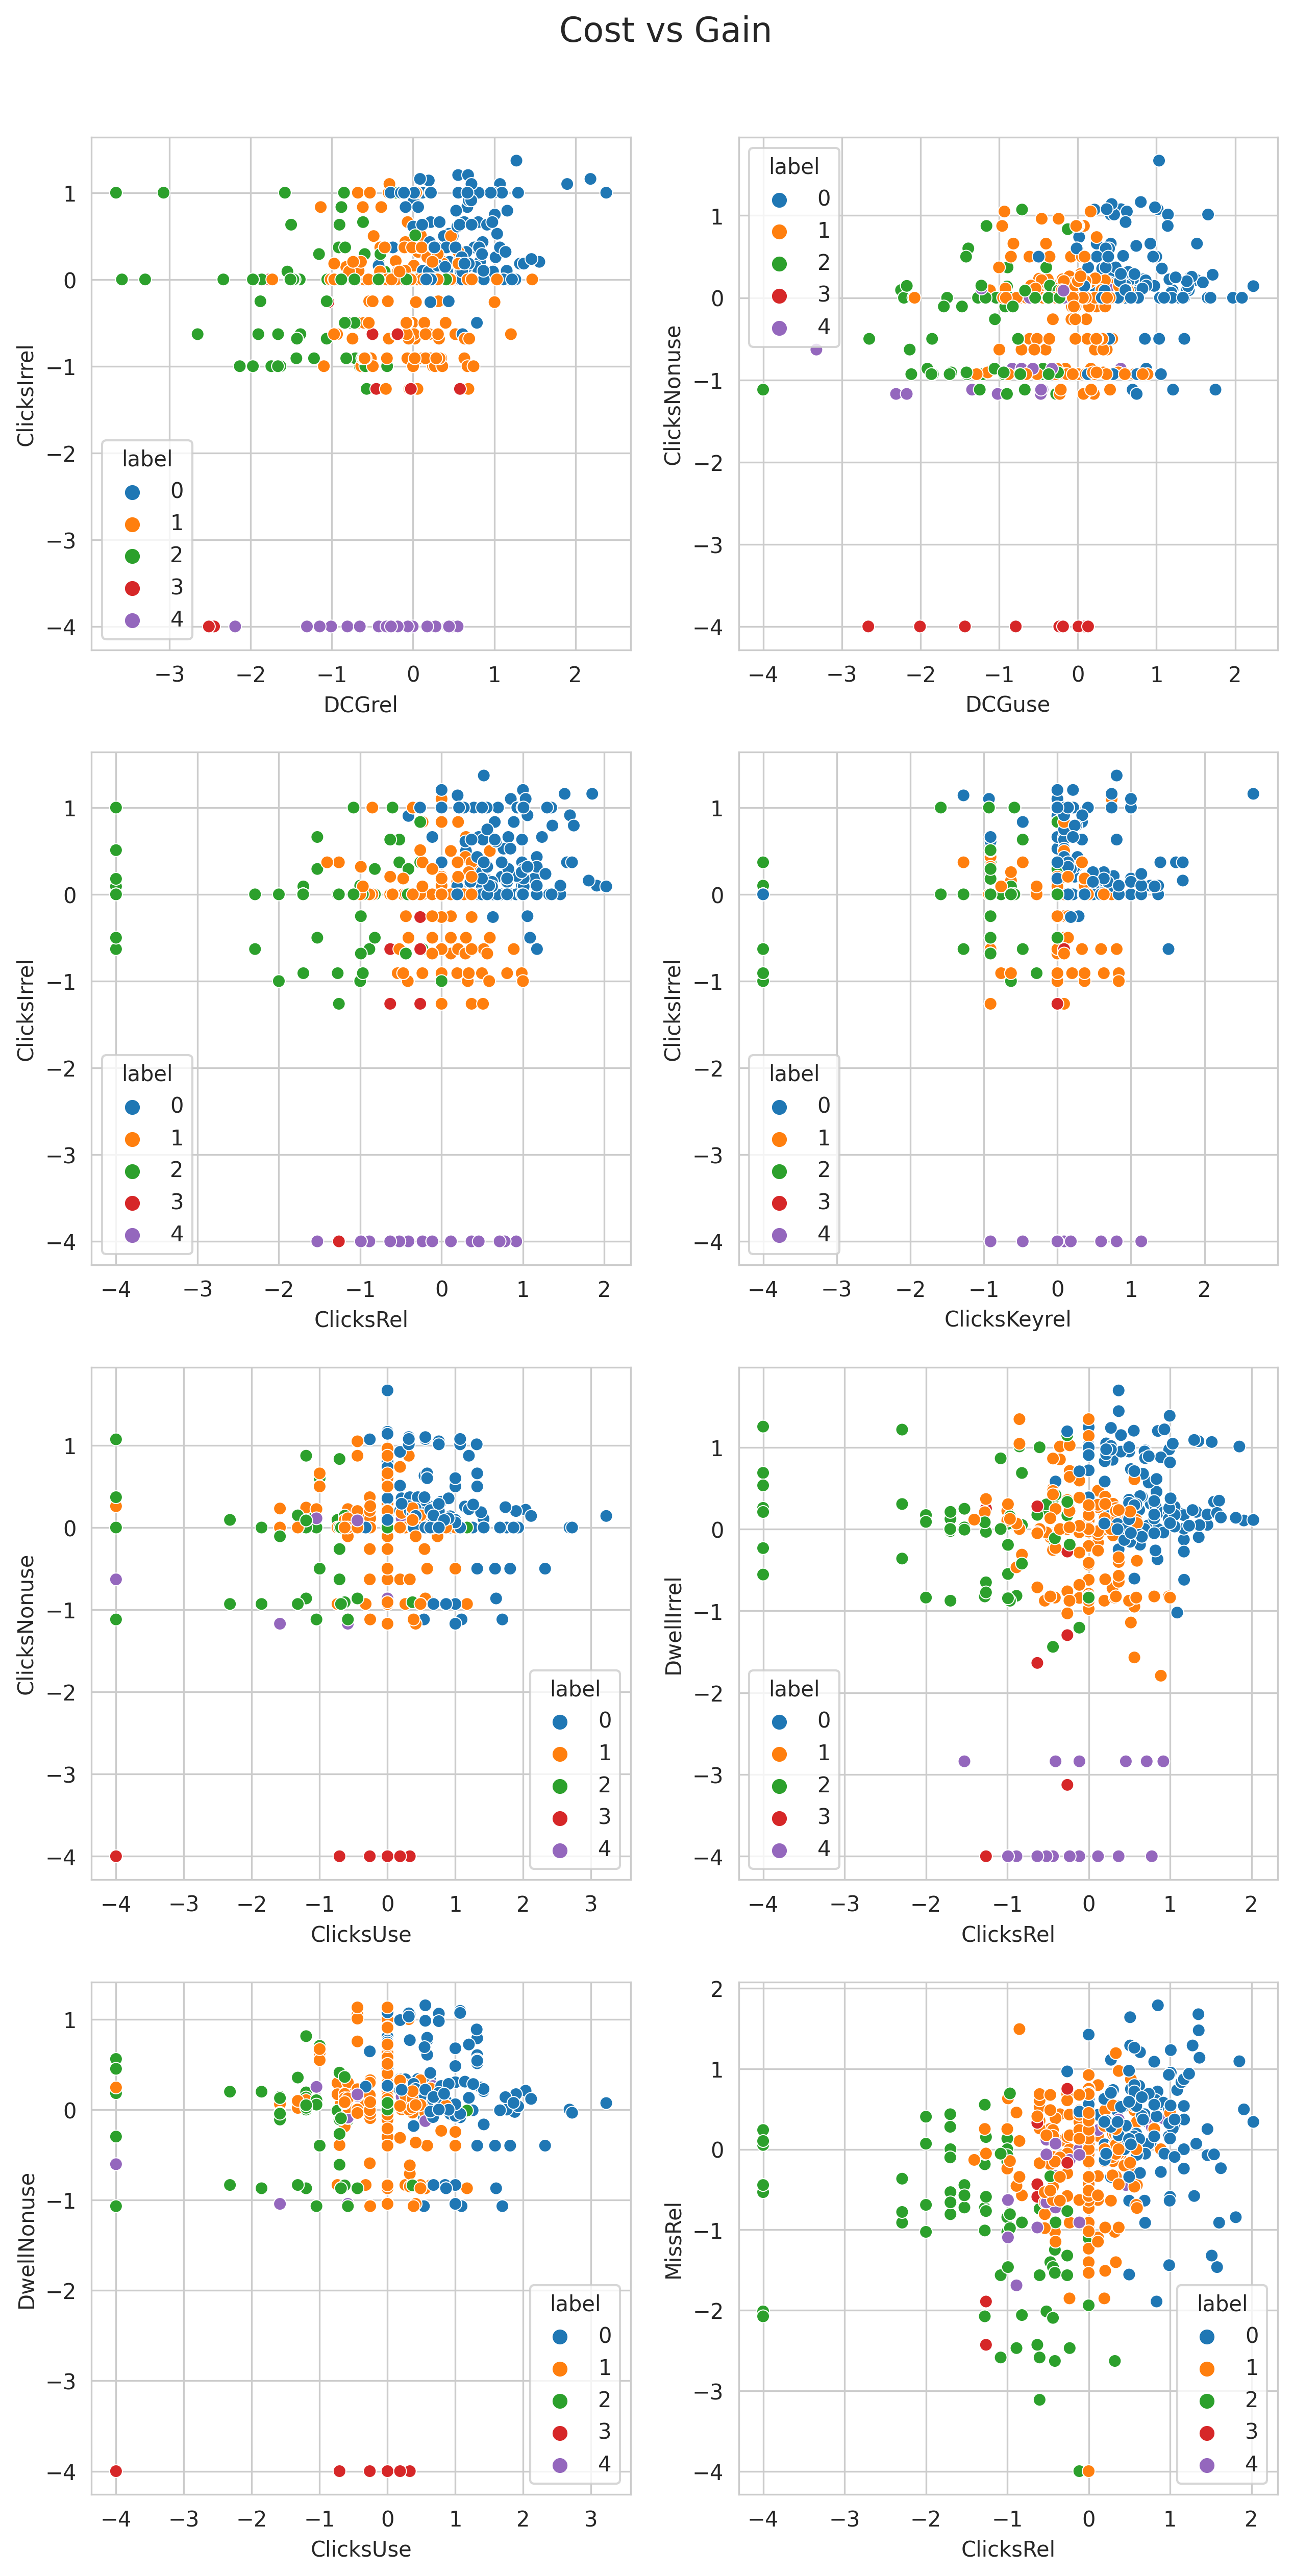

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(10,20),dpi=300)
for i in range(len(gain_cost_pair)):
    pair = gain_cost_pair[i]
    rename_label = pair[0]
    if 'dcg' in pair[0]:
        rename_label = pair[0].replace('dcg_','DCG')
    ax[i//2,i%2].set_xlabel(rename_label)
    ax[i//2,i%2].set_ylabel(pair[1])

    sns.scatterplot(x=pair[0],y=pair[1],
                    hue='label',
                    data=clusters,ax=ax[i//2,i%2],
                    palette="tab10")

fig.suptitle('Cost vs Gain', fontsize=16, y=0.92)
plt.show()

In [ ]:
tasks_list = list(eval_session['task'].drop_duplicates().values)
clusters['task']=eval_session['task']
clusters['session'] = eval_session['session']

In [ ]:
good_cluster = 0
clusters['label_bi'] = clusters['label'].where(clusters['label']==good_cluster,other=1)
clusters['label_bi'] = 1 - clusters['label_bi']
# clusters['label_bi'] = clusters['label_bi'].where(clusters['label_bi']==0,other=1)

In [ ]:
clusters['satisfaction'] = eval_session['satisfaction']
print(stats.kruskal(clusters.loc[clusters['label_bi']==0]['satisfaction'],
                    clusters.loc[clusters['label_bi']==1]['satisfaction']))

print(stats.ttest_ind(clusters.loc[clusters['label_bi']==0]['satisfaction'],
                    clusters.loc[clusters['label_bi']==1]['satisfaction']))
print(stats.kruskal(clusters.loc[clusters['label']==0]['satisfaction'],
                    clusters.loc[clusters['label']==1]['satisfaction'],
                    clusters.loc[clusters['label']==2]['satisfaction'],
                    clusters.loc[clusters['label']==3]['satisfaction'],
                    clusters.loc[clusters['label']==4]['satisfaction']))

KruskalResult(statistic=2.2185379365495836, pvalue=0.1363621409011974)
Ttest_indResult(statistic=1.8117141251951248, pvalue=0.07069984788097707)
KruskalResult(statistic=23.80163959740545, pvalue=8.753000237666946e-05)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


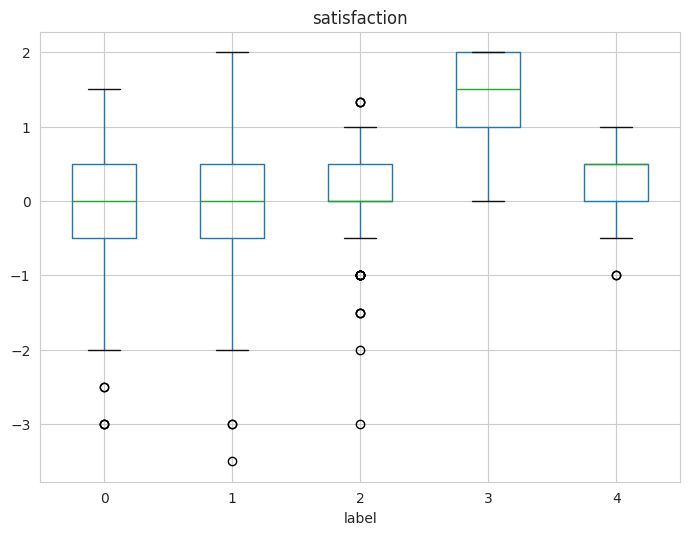

In [ ]:
clusters.boxplot(column='satisfaction',by='label')
plt.title('satisfaction' )
plt.suptitle('')
plt.show()

In [ ]:
# fig, ax = plt.subplots(4,2, figsize=(10,20))
# for i in range(len(gain_cost_pair)):
#     pair = gain_cost_pair[i]
#     ax[i//2,i%2].set_xlabel(pair[0])
#     ax[i//2,i%2].set_ylabel(pair[1])

#     sns.scatterplot(x=pair[0],y=pair[1],
#                     hue='label_bi',
#                     data=clusters,ax=ax[i//2,i%2],
#                     palette="tab10")

# fig.suptitle('Gain vs Cost (Total)', fontsize=16, y=0.92)
# plt.show()

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        layers.Dense(128,
        input_shape=(X_train.shape[-1],)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model

BATCH_SIZE = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [ ]:
data_feat = data_eval[behaviors].copy()
data_feat = data_feat.astype(float)
data_feat['task'] = data_eval['task_id']

In [ ]:
def SplitQueryOrder(query_order=None, increment=False):
    data_feat['session'] = data_eval['session']
    data_feat_avg = pd.DataFrame()
    for session in sessions_list:
        if query_order == None:
            data_s = data_eval.loc[data_eval['session']==session]
        else:
            data_s = data_eval.loc[data_eval['session']==session].head(query_order)
        if increment==True:
            data_s = data_eval.loc[data_eval['session']==session].head(query_order+1)
            row = data_s[behaviors].diff().mean()
        else:
            row = data_s[behaviors].mean()
        row['task'] = session.split('-')[1]

        data_feat_avg = data_feat_avg.append(row,ignore_index=True)

    data_feat_avg['task'] = data_feat['task']
    data_feat_avg = data_feat_avg.groupby('task').transform(
        lambda x: (x - x.median())/(x.quantile(0.75) - x.quantile(0.25)
                                    if x.quantile(0.75)>x.quantile() else 1))
    data_feat_avg = np.clip(data_feat_avg, -4, 4)

    behaviors_avg = behaviors.copy()
    behaviors_avg.remove('PageVisit')
    behaviors_avg.remove('Clicks@5+')
    features_array_avg = np.array(data_feat_avg[behaviors_avg])

    return features_array_avg

In [ ]:
X = SplitQueryOrder()

In [ ]:
y = clusters['label_bi']
total=len(y)
pos = len(y[(y==1)])
neg = total-pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight_gain = {0: weight_for_0, 1: weight_for_1}
class_weight_gain

{0: 0.7120253164556962, 1: 1.6791044776119404}

In [ ]:
# X = SplitQueryOrder()
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,test_size=0.1,random_state=i)

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train,test_size=0.2,random_state=i)

In [ ]:
accuracy_hist = {}
precision_hist = {}
recall_hist = {}
f1_hist = {}
model_members = {}
for i in tqdm(range(20)):
    for q in range(1,10):
        X = SplitQueryOrder(query_order=q)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,test_size=0.2,random_state=i)

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,test_size=0.2,random_state=i)
        saved_model = os.listdir('/content/drive/MyDrive/Data/')
        if 'kdd_model_{}_{}'.format(i,q) in saved_model:
            model = tf.keras.models.load_model('/content/drive/MyDrive/Data/kdd_model_{}_{}'.format(i,q))
        else:
            model = make_model()
            model.fit(
                X_train,
                y_train,
                epochs=50,
                batch_size=BATCH_SIZE,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping],
                class_weight=class_weight_gain,
                verbose=0)
            model.save('/content/drive/MyDrive/Data/kdd_model_{}_{}'.format(i,q))
        if q not in model_members:
            model_members[q] = [model]
        else:
            model_members[q].append(model)
        y_pred = model(X_test)
        y_pred = np.round(y_pred)
        # precision, recall, f1, _ = score(y_test, y_pred, zero_division=0)

        accuracy = accuracy_score(y_test,y_pred)
        precision = precision_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        f1 = f1_score(y_test,y_pred)

        if q in accuracy_hist:
            accuracy_hist[q].append(accuracy)
            precision_hist[q].append(precision)
            recall_hist[q].append(recall)
            f1_hist[q].append(f1)
        else:
            accuracy_hist[q] = [accuracy]
            precision_hist[q] = [precision]
            recall_hist[q] = [recall]
            f1_hist[q] = [f1]

100%|██████████| 20/20 [12:40<00:00, 38.01s/it]


In [ ]:
model_members = {}
for i in tqdm(range(20)):
    for q in range(1,10):
        model = tf.keras.models.load_model('/content/drive/MyDrive/Data/kdd_model_{}_{}'.format(i,q))
        if q not in model_members:
            model_members[q] = [model]
        else:
            model_members[q].append(model)

100%|██████████| 20/20 [12:21<00:00, 37.07s/it]


In [ ]:
pred_results = pd.DataFrame()
for q in range(1,10):
    result_dict = {}
    result_dict['QueryOrder'] = q
    result_dict['Accuracy'] = np.mean(accuracy_hist[q])
    result_dict['Precision'] = np.mean(precision_hist[q])
    result_dict['Recall'] = np.mean(recall_hist[q])
    result_dict['f1'] = np.mean(f1_hist[q])
    pred_results = pred_results.append(result_dict, ignore_index=True)

In [ ]:
pred_results.to_csv('/content/drive/MyDrive/Data/KDD_pred_results.csv')

In [ ]:
pred_results = pd.read_csv('/content/drive/MyDrive/Data/KDD_pred_results.csv', index_col = [0])

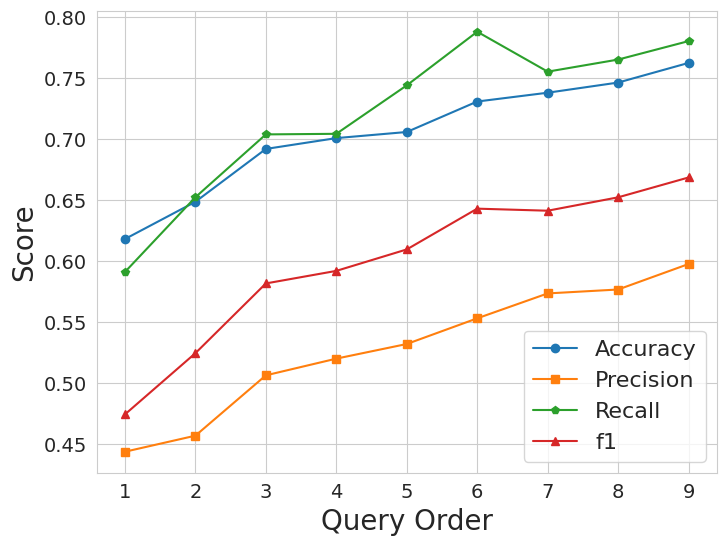

In [ ]:
from  matplotlib import ticker
from  matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

marker_list = ['o','s','p','^']
i=0
for score in ['Accuracy','Precision','Recall','f1']:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel('Query Order',fontsize=20)
    ax.set_ylabel('Score',fontsize=20)
    ax.set_xticklabels(range(0,11),fontsize=14)
    plt.rc('ytick', labelsize=14)
    #sns.lineplot(x='QueryOrder',y=score,data=pred_results,ax=ax,label=score,palette='tab10')
    plt.plot(pred_results['QueryOrder'],pred_results[score],marker=marker_list[i],label=score)
    i+=1
plt.legend(prop={"size":16})
plt.show()

In [ ]:
def PerformanceComparing(target,good,query_order,metrics):
    task_performance = {}
    for task in tasks_list:
        cluster_task = clusters.loc[clusters['task']==task].copy()
        cluster_query = data_eval.loc[data_eval['task_id'].astype('string')==task].copy()
        cluster_query = pd.merge(cluster_query,cluster_task[['session',target]],on='session', how='left')

        good_cluster = good
        good_query = cluster_query.loc[cluster_query[target]==good_cluster]
        task_cluster_performance = {}

        rest_cluster = set(clusters[target])
        rest_cluster.remove(good_cluster)

        for i in rest_cluster:
            cluster = cluster_query.loc[cluster_query[target]==i].copy()
            if len(cluster):
                task_cluster_performance[i] = {}
                curr_session = ''
                task_cluster_performance[i]['Original'] = []
                task_cluster_performance[i]['Recommend'] = []
                task_cluster_performance[i]['Replace'] = []
                head_rows = query_order
                curr_row = 1
                for index, row in cluster.iterrows():
                    if row['session'] != curr_session:
                        if curr_row < head_rows:
                            curr_row += 1
                            continue
                        else:
                            curr_session = row['session']
                            curr_query_token = row['QueryToken']
                            good_query_type = good_query.loc[good_query['query_order']==head_rows].copy().reset_index()
                            good_query_type['ShareTerm'] = good_query_type['QueryToken'].apply(
                                lambda x: len(set(curr_query_token) & set(x)))
                            good_query_type['similarity'] = (good_query_type['ShareTerm']/good_query_type['QueryToken'].apply(lambda x: len(x)))
                            # good_query_type['similarity']=util.pytorch_cos_sim(s2vmodel.encode(row['query']), good_query_type['vector']).numpy()[0]
                            good_query_type.sort_values('similarity',ascending=False,ignore_index=True)
                            matched_sessions = good_query_type['session'].values[0:min(5,len(good_query_type))]
                    else:
                        curr_row = 1
                        task_cluster_performance[i]['Original'].append(
                            row[metrics]
                        )
                        curr_query_token = row['QueryToken']
                        good_query_type = good_query.copy()
                        good_query_type['ShareTermL'] = good_query_type['QueryToken'].apply(
                            lambda x: len(set(last_query_token) & set(x)))
                        good_query_type['ShareTermC'] = good_query_type['QueryToken'].apply(
                            lambda x: len(set(curr_query_token) & set(x)))
                        good_query_common = good_query_type.loc[good_query_type['ShareTermL']>0]
                        good_query_new = good_query_type.loc[good_query_type['ShareTermL']==0].copy()

                        if len(set(last_query_token) & set(curr_query_token)):
                            if len(curr_query_token) > len(last_query_token):
                                recommend_list = good_query_common.loc[good_query_common['TokenLength'] > len(last_query_token)].copy()
                            if len(curr_query_token) == len(last_query_token):
                                recommend_list = good_query_common.loc[good_query_common['TokenLength'] == len(last_query_token)].copy()
                            if len(curr_query_token) < len(last_query_token):
                                recommend_list = good_query_common.loc[good_query_common['TokenLength'] < len(last_query_token)].copy()
                        else:
                            recommend_list = good_query_new
                        recommend_list = recommend_list.reset_index()

                        recommend_list['similarity'] = (recommend_list['ShareTermC']/
                                                        recommend_list['QueryToken'].apply(lambda x: len(x)))

                        if len(recommend_list) != 0:
                            recommend_list['similarity'] = (recommend_list['ShareTermC']/recommend_list['QueryToken'].apply(lambda x: len(x)))
                            # recommend_list['similarity']=util.pytorch_cos_sim(s2vmodel.encode(row['query']), recommend_list['vector']).numpy()[0]
                            recommend_list.sort_values('similarity',ascending=False,ignore_index=True)
                            task_cluster_performance[i]['Recommend'].append(
                                list(recommend_list[metrics].values)
                            )
                        switched_list = good_query.loc[(good_query['session'].isin(matched_sessions)) & (good_query['query_order']==row['query_order'])]
                        if len(switched_list) != 0:
                            task_cluster_performance[i]['Replace'].append(
                                list(switched_list[metrics].values)
                            )
                    last_query = row['query']
                    last_query_token = row['QueryToken']

        task_performance[task] = task_cluster_performance
    return task_performance

In [ ]:
performance_result = PerformanceComparing('label_bi',1,1,'ndcg_r')

In [ ]:
rest_cluster = {0,1}
rest_cluster.remove(1)
original = []
recommend = []
replace = []
for task in tasks_list:
    for cluster in rest_cluster:
        if performance_result[task][cluster]['Recommend'] != []:
            original.extend(performance_result[task][cluster]['Original'])
            recommend.extend([item[0] for item in performance_result[task][cluster]['Recommend']])
        if performance_result[task][cluster]['Replace'] != []:
            replace.extend([item[0] for item in performance_result[task][cluster]['Replace']])

In [ ]:
print(len(original),len(recommend),len(replace))
print(sum(original)/len(original),sum(recommend)/len(recommend),sum(replace)/len(replace))
print(stats.ttest_ind(recommend, original))
print(stats.ttest_ind(recommend, replace))

555 542 549
0.8463803042301759 0.8805944892382402 0.8724588163012751
Ttest_indResult(statistic=5.075405852166541, pvalue=4.5404100985879814e-07)
Ttest_indResult(statistic=1.393168739436975, pvalue=0.16385307045482425)


In [ ]:
for score in ['dcg_rel','ndcg_r','rr_r','dcg_use','ndcg_u','rr_u']:
    performance_result = PerformanceComparing('label_bi',1,1,score)
    rest_cluster = {0,1}
    rest_cluster.remove(1)
    original = []
    recommend = []
    replace = []
    for task in tasks_list:
        for cluster in rest_cluster:
            if performance_result[task][cluster]['Recommend'] != []:
                original.extend(performance_result[task][cluster]['Original'])
                recommend.extend([sum(item[:5])/len(item[:5]) for item in performance_result[task][cluster]['Recommend']])
                # recommend.extend([item[0] for item in performance_result[task][cluster]['Recommend']])
            if performance_result[task][cluster]['Replace'] != []:
                replace.extend([sum(item)/len(item) for item in performance_result[task][cluster]['Replace']])
                # replace.extend([item[0] for item in performance_result[task][cluster]['Replace']])
    print(score)
    print(len(original),'\n',len(replace),'\n',len(recommend))
    print(sum(original)/len(original),'\n',sum(replace)/len(replace),'\n',sum(recommend)/len(recommend))
    print(stats.ttest_ind(replace, original))
    print(stats.ttest_ind(recommend, original))
    print(stats.ttest_ind(recommend, replace))

dcg_rel
555 
 549 
 542
6.993422012796285 
 7.4358839326394515 
 7.159496232591311
Ttest_indResult(statistic=2.8998196414961828, pvalue=0.00380787008335309)
Ttest_indResult(statistic=1.0312188497740837, pvalue=0.30266591440257834)
Ttest_indResult(statistic=-2.300423569144846, pvalue=0.021612552025118307)
ndcg_r
555 
 549 
 542
0.8415625953893935 
 0.865831591698402 
 0.8540008312118954
Ttest_indResult(statistic=4.209857306084413, pvalue=2.763511285448923e-05)
Ttest_indResult(statistic=1.6259636846053418, pvalue=0.10424511909703747)
Ttest_indResult(statistic=-1.9840883998794592, pvalue=0.0474967080155159)
rr_r
555 
 549 
 542
2.9207207207207206 
 2.424013357619917 
 2.584747847478483
Ttest_indResult(statistic=-3.827645689184788, pvalue=0.00013665238600680762)
Ttest_indResult(statistic=-2.554262583344704, pvalue=0.010775748389978143)
Ttest_indResult(statistic=1.9172271927240743, pvalue=0.05547047977125978)
dcg_use
555 
 549 
 542
2.666110629664796 
 3.151152887182918 
 3.3104540786750185

In [ ]:
y_hat = {}
for q in range(1,5):
    X = SplitQueryOrder(query_order=q)
    model_list = model_members[q]
    yhats = [model.predict(X) for model in model_list]
    y_hat[q] = np.round(np.mean(yhats, axis=0))

In [ ]:
for q in range(1,5):
    print(q)
    for score in ['dcg_rel','ndcg_r','rr_r','dcg_use','ndcg_u','rr_u']:
        y_hat_label = y_hat[q]
        clusters['label_hat'] = y_hat_label
        performance_result = PerformanceComparing('label_hat',1,q,score)
        rest_cluster = {0,1}
        rest_cluster.remove(1)
        original = []
        recommend = []
        replace = []
        for task in tasks_list:
            for cluster in rest_cluster:
                if performance_result[task][cluster]['Recommend'] != []:
                    original.extend(performance_result[task][cluster]['Original'])
                    recommend.extend([sum(item[:5])/len(item[:5]) for item in
                                    performance_result[task][cluster]['Recommend']])
                if performance_result[task][cluster]['Replace'] != []:
                    replace.extend([item[0] for item in performance_result[task][cluster]['Replace']])
        print(score)
        print(len(original),'\n',len(replace),'\n',len(recommend))
        print(sum(original)/len(original),'\n',sum(replace)/len(replace),'\n',sum(recommend)/len(recommend))
        print(stats.ttest_ind(replace, original))
        print(stats.ttest_ind(recommend, original))
        print(stats.ttest_ind(recommend, replace))

1
dcg_rel
711 
 582 
 688
6.871956152972712 
 7.608881318631801 
 7.326970003251759
Ttest_indResult(statistic=4.851647161301414, pvalue=1.3734832522825891e-06)
Ttest_indResult(statistic=3.387393549861713, pvalue=0.0007252166721646661)
Ttest_indResult(statistic=-2.4667142712141277, pvalue=0.013767342973089408)
ndcg_r
711 
 582 
 688
0.845761272167539 
 0.8593604636828597 
 0.8549508424277511
Ttest_indResult(statistic=2.3771496542166775, pvalue=0.0175920269600039)
Ttest_indResult(statistic=1.841927701937771, pvalue=0.06569757246177113)
Ttest_indResult(statistic=-1.2229073138134257, pvalue=0.2215919412574971)
rr_r
711 
 582 
 688
2.942334739803094 
 2.4054982817869415 
 2.5200581395348784
Ttest_indResult(statistic=-4.194749691563629, pvalue=2.91826648026511e-05)
Ttest_indResult(statistic=-3.783272674336355, pvalue=0.0001613215764520025)
Ttest_indResult(statistic=1.4397481238791499, pvalue=0.15018550136287764)
dcg_use
711 
 582 
 688
2.6061257800561326 
 3.2050137636290548 
 3.767862899622